In [1]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

from polModel import PolModel
from draine_dust_2D import draine_dust
from model_spec import model_spec

In [2]:
#General plotting function
def pol_plot(mod_p, spec):

    data = np.loadtxt("pol_measurements.dat", usecols=[1,2])
    p_measured = data[:,0]
    p_unc = data[:,1]

    wave = np.array([5500., 6500., 8000.]) / spec.zspec

    fig, ax = plt.subplots(1)

    ax.errorbar(wave, p_measured, yerr=p_unc, fmt='ko', label='Measurements')
    for scat_type in mod_p.keys():
        ax.plot(wave, mod_p[scat_type], 's', label=scat_type)

    ax.legend()
    ax.set_xlabel('Wavelength (Angstroms)')
    ax.set_ylabel('Polarization fraction')
    plt.show()

## Model the SDSS Spectrum

In [3]:
spec, model = model_spec()

In [4]:
#Assume that Lyman alpha is also polarized in the same manner as all the other emission lines. 
model.multi_line[0].pol = True
model.multi_line[1].pol = True

### Pure Gas Models.

In [5]:
#Define the object
class Gas_Gas(object):
    def get_theta(self, lam_rest):
        return np.ones(len(lam_rest))
    def get_theta_A(self, x, lam_rest):
        return self.get_theta(lam_rest)
    def get_theta_B(self, x, lam_rest):
        return self.get_theta(lam_rest)

In [6]:
#Set the objects
scat_obj = Gas_Gas()
pol_model = PolModel(spec, model)

#Run the fits
x0 = np.array([0.15, 0.15, 45.])
min_vals = np.array([0., 0., 0.])
max_vals = np.array([1., 1., 90.])
pol_model.fit_pol(scat_obj, x0, min_vals, max_vals)
print(pol_model.xopt)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 21.26549452884097
       x: [ 1.187e-01  9.799e-02  1.486e-04]
     nit: 15
     jac: [ 3.735e-01 -1.148e-01  5.436e-05]
    nfev: 65
    njev: 15


In [7]:
xopt_all = dict()
mod_p_all = dict()
xopt_all["Gas"] = pol_model.xopt
mod_p_all["Gas"] = pol_model.mod_p

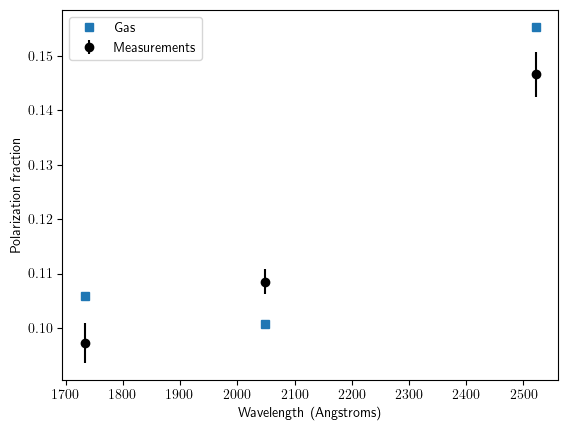

In [8]:
pol_plot(mod_p_all, spec)

### Pure Dust Models.

In [9]:
#Define the object.
class Dust_Dust(object):

    def __init__(self, dust_type):
        #Load the dust model. 
        self.dust = draine_dust(dust_type)
        return

    def get_theta(self, x, lam_rest):
        phi = x[3]
        return self.dust.pfrac(lam_rest.to(u.um).value, phi).flatten()
    
    def get_theta_A(self, x, lam_rest):
        return self.get_theta(x, lam_rest)
    
    def get_theta_B(self, x, lam_rest):
        return self.get_theta(x, lam_rest)



In [10]:
dust_types = ["SMC", "LMC", "MW"]

In [11]:
for dust_type in dust_types:
    #Set the objects
    scat_obj = Dust_Dust(dust_type)

    #Run the fits. Attempt a start with scattering angle < 90. and > 90.
    x0 = np.array([0.5, 0.5, 70., 90.])
    min_vals = np.array([0., 0., 0., 0.])
    max_vals = np.array([1., 1., 90., 180.])
    for i in range(2):
        if i==0:
            x0[-1] = 60.
        else:
            x0[-1] = 170.
        pol_model_aux = PolModel(spec, model)
        pol_model_aux.fit_pol(scat_obj, x0, min_vals, max_vals)
        if i==0 or pol_model_aux.xopt.fun < pol_model.xopt.fun:
            pol_model = pol_model_aux

    print(pol_model.xopt)

    #Save the results.
    xopt_all["DD_"+dust_type] = pol_model.xopt
    mod_p_all["DD_"+dust_type] = pol_model.mod_p



 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 2.3049987206585774e-08
       x: [ 9.590e-01  9.596e-01  8.260e+01  7.688e+01]
     nit: 32
     jac: [ 2.700e-02 -7.350e-03 -1.868e-04  2.773e-04]
    nfev: 173
    njev: 32
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 195.1923104166832
       x: [ 1.000e+00  6.679e-01  7.276e+01  6.032e+01]
     nit: 33
     jac: [-4.167e+02  8.755e-04 -1.640e-04  3.510e-04]
    nfev: 181
    njev: 32
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 7.926012923664e-09
       x: [ 1.000e+00  5.959e-01  6.721e+01  5.498e+01]
     nit: 32
     jac: [-2.597e-04 -1.535e-03  1.561e-05  3.815e-05]
    nfev: 169
    njev: 32


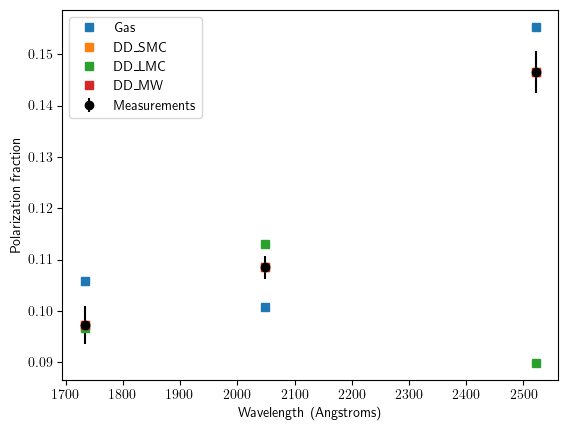

In [12]:
pol_plot(mod_p_all, spec)

### Dust for continuum, Gas for emission lines.

In [13]:
class Dust_Gas(Dust_Dust):

    def __init__(self, dust_type):
        #Load the dust model. 
        self.dust = draine_dust(dust_type)
        return

    def get_theta_A(self, x, lam_rest):
        phi = x[3]
        return self.dust.pfrac(lam_rest.to(u.um).value, phi).flatten()
    
    def get_theta_B(self, x, lam_rest):
        return np.ones(len(spec.lam_rest))

In [15]:
for dust_type in dust_types:
    #Set the objects
    scat_obj = Dust_Gas(dust_type)

    #Run the fits. Attempt a start with scattering angle < 90. and > 90.
    x0 = np.array([0.9, 0.9, 50., 90.])
    min_vals = np.array([0., 0., 0., 0.])
    max_vals = np.array([1., 1., 90., 180.])
    for i in range(2):
        if i==0:
            x0[-1] = 60.
        else:
            x0[-1] = 170.
        pol_model_aux = PolModel(spec, model)
        pol_model_aux.fit_pol(scat_obj, x0, min_vals, max_vals)
        if i==0 or pol_model_aux.xopt.fun < pol_model.xopt.fun:
            pol_model = pol_model_aux

    print(pol_model.xopt)

    #Save the results.
    xopt_all["DG_"+dust_type] = pol_model.xopt
    mod_p_all["DG_"+dust_type] = pol_model.mod_p



 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 716.3608774682575
       x: [ 1.000e+00  1.450e-09  7.259e+01  1.413e+02]
     nit: 6
     jac: [-7.857e+02  1.165e+03  0.000e+00  6.104e-04]
    nfev: 43
    njev: 6
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 132.8732151795853
       x: [ 1.000e+00  7.811e-02  9.000e+01  1.277e+02]
     nit: 17
     jac: [-4.738e+02  1.157e-01  0.000e+00  3.017e-03]
    nfev: 92
    njev: 17
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 360.4159988919648
       x: [ 1.000e+00  2.739e-02  9.000e+01  1.273e+02]
     nit: 14
     jac: [-6.697e+02 -4.731e-02  0.000e+00 -5.150e-04]
    nfev: 85
    njev: 14


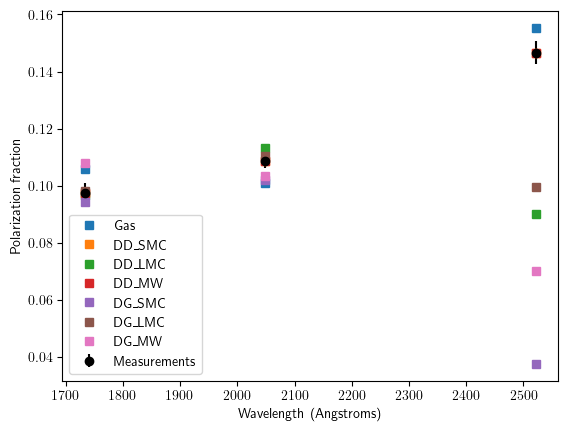

In [16]:
pol_plot(mod_p_all, spec)